# AlgebraicPetri Application Demo

[AlgebraicPetri.jl](https://algebraicjulia.github.io/AlgebraicPetri.jl/dev/) is a library which simultaneously provides modelers access to the model construction and analysis tools contained in [AlgebraicJulia](https://www.algebraicjulia.org/) and the simulation and analysis tools contained in [SciML](https://sciml.ai/).

In [1]:
# Necessary imports 
using AlgebraicPetri
using AlgebraicPetri.ModelComparison
using Semagrams, Semagrams.Examples
using Catlab
using Catlab.CategoricalAlgebra
using DifferentialEquations
using Plots
using JSON
using LabelledArrays
using PrettyTables

include("../src/ModelStratify.jl")
include("../src/Sensitivity.jl")
include("../src/EpiModel.jl")
using .ModelStratify
using .Sensitivity
using .EpiModel;

solution(model::LabelledReactionNet, tspan) = begin
    solve(ODEProblem(vectorfield(model), concentrations(model), tspan, rates(model)), Tsit5())
end
default(linewidth=5, xaxis="Time", yaxis="Population")
function sens_table(sens; kw...)
    sens_matrix = hcat(collect(keys(sens)), collect(values(sens)))
    pretty_table(sens_matrix[sortperm(sens_matrix[:, 2]; rev=true), :]; header=(["Transition", "Sensitivity"],), kw...)
end;
function signed_log(vals)
    scale_fac = 1.0/(minimum(abs.(vals)) + 1e-10)
    log_sens = log10.(abs.((vals .+ 1e-10) .* scale_fac)) .* sign.(vals)
end;
get_ptnet(a) = begin
    epn = get_acset(a)
    pn = LabelledReactionNet(epn)
    set_subparts!(pn, 1:nt(pn),
        rate=map(r->try parse(Float64, r) catch e;  (t...)->Base.invokelatest(eval(Meta.parse(r)), t...) end,
            subpart(pn, :rate)))
    pn
end

flt_rates(pn) = begin
    r = rates(pn)
    l = findall(t-> t isa Float64, r)
    Dict(zip(l, r[l]))
    @LArray r[l] Tuple(l)
end

function show_graph(g)
    display("text/html",html"<style>div.graphs svg{max-width:100% !important;max-height:100% !important;</style>")
    display("text/html", "<div class=graphs>" * read(Catlab.Graphics.Graphviz.run_graphviz(g, format = "svg"), String) * "</div>")
end;

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1502388450948850230\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-3056279965230204416\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1502388450948850230\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [10]:
export_html(p)

HTML{String}("<svg xmlns=\"http://www.w3.org/2000/svg\" width=\"95%\" height=\"300px\"><style>\n.katex { font-size: 1.5em; }\n</style><defs><pattern id=\"grid\" width=\"30\" height=\"30\" x=\"0\" y=\"0\" patternUnits=\"userSpaceOnUse\"><path d=\"M 30,0 L 0,0 L 0,30\" fill=\"none\" stroke=\"gray\" stroke-width=\"1\"/></pattern><marker id=\"resistor\" viewBox=\"0 0 82.5 30\" refX=\"45\" refY=\"15\" markerWidth=\"30\" markerHeight=\"10\" orient=\"auto\"><g transform=\"translate(0 15)\"><rect width=\"90\" height=\"30\" x=\"0\" y=\"-15\" style=\"fill:black;stroke:none\"/><polyline points=\"0.0,0.0 15.0,0.0 22.5,-15.0 30.0,15.0 37.5,-15.0 45.0,15.0 52.5,-15.0 60.0,15.0 67.5,0.0 82.5,0.0\" style=\"stroke-width:2px;stroke:white;fill:none\"/></g></marker><marker id=\"capacitor\" viewBox=\"0 0 60 60\" refX=\"30\" refY=\"30\" markerWidth=\"20\" markerHeight=\"20\" orient=\"auto\"><g transform=\"translate(30 30)\"><rect width=\"60\" height=\"60\" x=\"-30\" y=\"-30\" style=\"stroke: none; fill: black;\"/><polyline points=\"-30,0 -10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"30,0 10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"-10,30 -10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"10,30 10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/></g></marker><marker id=\"arrow-hovered\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"lightgrey\" stroke=\"black\"/></marker><marker id=\"arrow\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"white\" stroke=\"black\"/></marker><marker id=\"arrow-selected\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"yellow\" stroke=\"black\"/></marker><marker id=\"arrow-solid\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"black\" stroke=\"black\"/></marker></defs><g transform=\"matrix(0.5 0 0 0.5 0 0)\"><g><path d=\"M 360,120 C 405,100 405,100 450,100 C 495,100 495,100 540,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 225,450 225,450 270,420 C 315,390 315,390 360,360\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,480 C 405,480 405,480 450,480 C 495,480 495,480 540,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 180,435 180,435 180,390 C 180,345 180,345 180,300\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,360 C 405,390 405,390 450,420 C 495,450 495,450 540,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 483,429 483,429 438,369 C 393,309 393,309 360,240\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 585,480 585,480 630,480 C 675,480 675,480 720,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 495,500 495,500 450,500 C 405,500 405,500 360,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 225,480 225,480 270,480 C 315,480 315,480 360,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 720,120 C 720,165 720,165 720,210 C 720,255 720,255 720,300\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,120 C 585,120 585,120 630,120 C 675,120 675,120 720,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,120 C 225,120 225,120 270,120 C 315,120 315,120 360,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,240 C 417,291 417,291 4

In [3]:
load(p, "SVIIR.sema");

In [4]:
model = get_ptnet(p)
show_graph(Graph(model, p; scale=144 * 0.8))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V 
 
<!-- t2 -->
 
 t2 
 
 β_{UV} 
 
<!-- s1->t2 -->
 
 s1->t2 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VV} 
 
<!-- s1->t4 -->
 
 s1->t4 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S 
 
<!-- t1 -->
 
 t1 
 
 ν 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t3 -->
 
 t3 
 
 β_{VU} 
 
<!-- s2->t3 -->
 
 s2->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 β_{UU} 
 
<!-- s2->t7 -->
 
 s2->t7 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R 
 
<!-- s4 -->
 
 s4 
 
 I_U 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 γ_U 
 
<!-- s4->t5 -->
 
 s4->t5 
 
 
 1 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 I_V 
 
<!-- s5->t3 -->
 
 s5->t3 
 
 
 1 
 
<!-- s5->t4 -->
 
 s5->t4 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 γ_V 
 
<!-- s5->t6 -->
 
 s5->t6 
 
 
 1 
 
<!-- t1->s1 -->
 
 t1->s1 
 
 
 1 
 
<!-- t2->s4 -->
 
 t2->s4 
 
 
 1 
 
<!-- t2->s5 -->
 
 t2->s5 
 
 
 1 
 
<!-- t3->s4 -->
 
 t3->s4 
 
 
 1 
 
<!-- t3->s5 -->
 
 t3->s5 
 
 
 1 
 
<!-- t4->s5 -->
 
 t4->s5 
 
 
 2 
 
<!-- t5->s3 -->
 
 t5->s3 
 
 
 1 
 
<!-- t6->s3 -->
 
 t6->s3 
 
 
 1 
 
<!-- t7->s4 -->
 
 t7->s4 
 
 
 2

### Code from Petrinet

In [5]:
using AlgebraicPetri.BilayerNetworks
bln = LabelledBilayerNetwork()
migrate!(bln, LabelledPetriNet(model))
BilayerNetworks.compile(bln, :du, :phi, :psi, rates(model))

:(f!(du, phi, psi, t) = begin
          #= /Users/abaas3/Documents/work/projects/act/aske/algebraic_petri/upstream/graphics_update/AlgebraicPetri.jl/src/BilayerNetworks.jl:269 =#
          begin
              #= /Users/abaas3/Documents/work/projects/act/aske/algebraic_petri/upstream/graphics_update/AlgebraicPetri.jl/src/BilayerNetworks.jl:274 =#
              du .= 0.0
              #= /Users/abaas3/Documents/work/projects/act/aske/algebraic_petri/upstream/graphics_update/AlgebraicPetri.jl/src/BilayerNetworks.jl:275 =#
              phi .= 1.0
              phi[3] *= psi[2]
              phi[1] *= psi[2]
              phi[2] *= psi[4]
              phi[5] *= psi[4]
              phi[7] *= psi[4]
              phi[7] *= psi[2]
              phi[6] *= psi[5]
              phi[4] *= psi[1]
              phi[2] *= psi[1]
              phi[4] *= psi[5]
              phi[3] *= psi[5]
              phi[1] *= 0.1
              phi[2] *= 0.0002
              phi[3] *= 0.001
              phi[4]

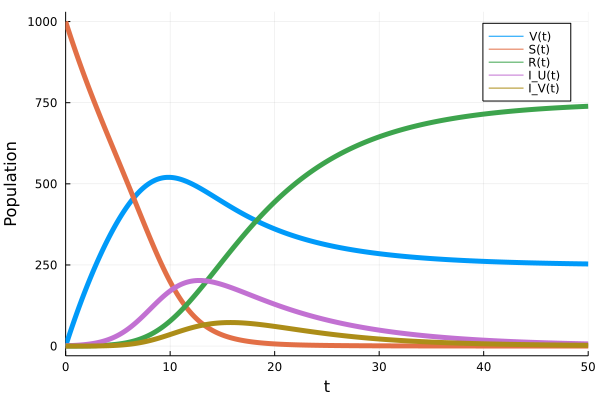

In [7]:
sol = solution(model, (0.0,50.0))
plot(sol)

In [8]:
int_met = Sensitivity.int_metric(model, [:R, :S, :V], t_range=(0.0,50.0))
sens = Sensitivity.sensitivity(int_met, flt_rates(model)) .* flt_rates(model) ./ int_met(flt_rates(model))
sens_table(sens)

┌────────────┬─────────────┐
│ Transition │ Sensitivity │
├────────────┼─────────────┤
│        γ_U │    0.101564 │
│          ν │   0.0961692 │
│        γ_V │   0.0363567 │
│     β_{VV} │ -0.00636655 │
│     β_{VU} │ -0.00815847 │
│     β_{UV} │  -0.0221078 │
│     β_{UU} │   -0.102475 │
└────────────┴─────────────┘


In [9]:
log_sens = signed_log(sens)
max_rng = maximum(abs.(log_sens))
show_graph(GraphHeatmap(model, log_sens, clims=(-max_rng, max_rng); positions=locations(model, save(p), scale=144 * 0.7)))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V 
 
<!-- t2 -->
 
 t2 
 
 β_{UV} 
 
<!-- s1->t2 -->
 
 s1->t2 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VV} 
 
<!-- s1->t4 -->
 
 s1->t4 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S 
 
<!-- t1 -->
 
 t1 
 
 ν 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t3 -->
 
 t3 
 
 β_{VU} 
 
<!-- s2->t3 -->
 
 s2->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 β_{UU} 
 
<!-- s2->t7 -->
 
 s2->t7 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R 
 
<!-- s4 -->
 
 s4 
 
 I_U 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 γ_U 
 
<!-- s4->t5 -->
 
 s4->t5 
 
 
 1 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 I_V 
 
<!-- s5->t3 -->
 
 s5->t3 
 
 
 1 
 
<!-- s5->t4 -->
 
 s5->t4 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 γ_V 
 
<!-- s5->t6 -->
 
 s5->t6 
 
 
 1 
 
<!-- t1->s1 -->
 
 t1->s1 
 
 
 1 
 
<!-- t2->s4 -->
 
 t2->s4 
 
 
 1 
 
<!-- t2->s5 -->
 
 t2->s5 
 
 
 1 
 
<!-- t3->s4 -->
 
 t3->s4 
 
 
 1 
 
<!-- t3->s5 -->
 
 t3->s5 
 
 
 1 
 
<!-- t4->s5 -->
 
 t4->s5 
 
 
 2 
 
<!-- t5->s3 -->
 
 t5->s3 
 
 
 1 
 
<!-- t6->s3 -->
 
 t6->s3 
 
 
 1 
 
<!-- t7->s4 -->
 
 t7->s4 
 
 
 2

## Add a hypothesized transition to the original model

In [12]:
export_html(p)

HTML{String}("<svg xmlns=\"http://www.w3.org/2000/svg\" width=\"95%\" height=\"300px\"><style>\n.katex { font-size: 1.5em; }\n</style><defs><pattern id=\"grid\" width=\"30\" height=\"30\" x=\"15\" y=\"-34\" patternUnits=\"userSpaceOnUse\"><path d=\"M 30,0 L 0,0 L 0,30\" fill=\"none\" stroke=\"gray\" stroke-width=\"1\"/></pattern><marker id=\"resistor\" viewBox=\"0 0 82.5 30\" refX=\"45\" refY=\"15\" markerWidth=\"30\" markerHeight=\"10\" orient=\"auto\"><g transform=\"translate(0 15)\"><rect width=\"90\" height=\"30\" x=\"0\" y=\"-15\" style=\"fill:black;stroke:none\"/><polyline points=\"0.0,0.0 15.0,0.0 22.5,-15.0 30.0,15.0 37.5,-15.0 45.0,15.0 52.5,-15.0 60.0,15.0 67.5,0.0 82.5,0.0\" style=\"stroke-width:2px;stroke:white;fill:none\"/></g></marker><marker id=\"capacitor\" viewBox=\"0 0 60 60\" refX=\"30\" refY=\"30\" markerWidth=\"20\" markerHeight=\"20\" orient=\"auto\"><g transform=\"translate(30 30)\"><rect width=\"60\" height=\"60\" x=\"-30\" y=\"-30\" style=\"stroke: none; fill: black;\"/><polyline points=\"-30,0 -10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"30,0 10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"-10,30 -10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"10,30 10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/></g></marker><marker id=\"arrow-hovered\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"lightgrey\" stroke=\"black\"/></marker><marker id=\"arrow\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"white\" stroke=\"black\"/></marker><marker id=\"arrow-selected\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"yellow\" stroke=\"black\"/></marker><marker id=\"arrow-solid\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"black\" stroke=\"black\"/></marker></defs><g transform=\"matrix(0.5 0 0 0.5 15 -34)\"><g><path d=\"M 360,120 C 405,100 405,100 450,100 C 495,100 495,100 540,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 225,450 225,450 270,420 C 315,390 315,390 360,360\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,480 C 405,480 405,480 450,480 C 495,480 495,480 540,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 180,435 180,435 180,390 C 180,345 180,345 180,300\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,360 C 405,390 405,390 450,420 C 495,450 495,450 540,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 483,429 483,429 438,369 C 393,309 393,309 360,240\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 585,480 585,480 630,480 C 675,480 675,480 720,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 495,500 495,500 450,500 C 405,500 405,500 360,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 225,480 225,480 270,480 C 315,480 315,480 360,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 720,120 C 720,165 720,165 720,210 C 720,255 720,255 720,300\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,120 C 585,120 585,120 630,120 C 675,120 675,120 720,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,120 C 225,120 225,120 270,120 C 315,120 315,120 360,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,240 C 417,291 417

In [11]:
model_susc = get_ptnet(p)
show_graph(Graph(model_susc, p, scale = 144 * 0.7))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V 
 
<!-- t2 -->
 
 t2 
 
 β_{UV} 
 
<!-- s1->t2 -->
 
 s1->t2 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 β_{VV} 
 
<!-- s1->t5 -->
 
 s1->t5 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S 
 
<!-- t1 -->
 
 t1 
 
 ν 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t3 -->
 
 t3 
 
 β_{VU} 
 
<!-- s2->t3 -->
 
 s2->t3 
 
 
 1 
 
<!-- t8 -->
 
 t8 
 
 β_{UU} 
 
<!-- s2->t8 -->
 
 s2->t8 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R 
 
<!-- t4 -->
 
 t4 
 
 σ 
 
<!-- s3->t4 -->
 
 s3->t4 
 
 
 1 
 
<!-- s4 -->
 
 s4 
 
 I_U 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 γ_U 
 
<!-- s4->t6 -->
 
 s4->t6 
 
 
 1 
 
<!-- s4->t8 -->
 
 s4->t8 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 I_V 
 
<!-- s5->t3 -->
 
 s5->t3 
 
 
 1 
 
<!-- s5->t5 -->
 
 s5->t5 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 γ_V 
 
<!-- s5->t7 -->
 
 s5->t7 
 
 
 1 
 
<!-- t1->s1 -->
 
 t1->s1 
 
 
 1 
 
<!-- t2->s4 -->
 
 t2->s4 
 
 
 1 
 
<!-- t2->s5 -->
 
 t2->s5 
 
 
 1 
 
<!-- t3->s4 -->
 
 t3->s4 
 
 
 1 
 
<!-- t3->s5 -->
 
 t3->s5 
 
 
 1 
 
<!-- t4->s2 -->
 
 t4->s2 
 
 
 1 
 
<!-- t5->s5 -->
 
 t5->s5 
 
 
 2 
 
<!-- t6->s3 -->
 
 t6->s3 
 
 
 1 
 
<!-- t7->s3 -->
 
 t7->s3 
 
 
 1 
 
<!-- t8->s4 -->
 
 t8->s4 
 
 
 2

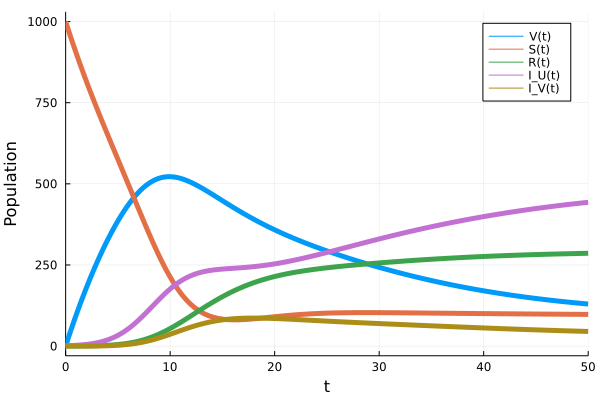

In [13]:
sol = solution(model_susc, (0.0, 50.0))
plot(sol)

In [14]:
int_met = int_metric(model_susc, [:R, :S, :V], t_range=(0.0,50.0))
sens = sensitivity(int_met, rates(model_susc)) .* rates(model_susc) ./ int_met(rates(model_susc))
sens_table(sens)

┌────────────┬─────────────┐
│ Transition │ Sensitivity │
├────────────┼─────────────┤
│          ν │    0.365404 │
│        γ_U │     0.34431 │
│        γ_V │   0.0910854 │
│     β_{VV} │  -0.0435335 │
│     β_{VU} │  -0.0587142 │
│          σ │     -0.1797 │
│     β_{UV} │   -0.190486 │
│     β_{UU} │   -0.560356 │
└────────────┴─────────────┘


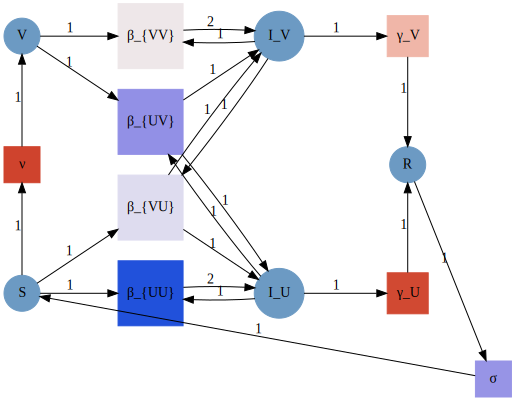

In [15]:
log_sens = signed_log(sens)
max_rng = maximum(abs.(log_sens))
GraphHeatmap(model_susc, log_sens; clims=(-max_rng, max_rng), positions=locations(model_susc, save(p), scale=144 * 0.7))

## Hypothesized stratification of model

### Specification of a Mixing Matrix

In [30]:
export_html(gen_graph)

HTML{String}("<svg xmlns=\"http://www.w3.org/2000/svg\" width=\"95%\" height=\"300px\"><style>\n.katex { font-size: 1.5em; }\n</style><defs><pattern id=\"grid\" width=\"39.930000000000014\" height=\"39.930000000000014\" x=\"-55.60800000000007\" y=\"-69.26175000000009\" patternUnits=\"userSpaceOnUse\"><path d=\"M 39.930000000000014,0 L 0,0 L 0,39.930000000000014\" fill=\"none\" stroke=\"gray\" stroke-width=\"1\"/></pattern><marker id=\"resistor\" viewBox=\"0 0 82.5 30\" refX=\"45\" refY=\"15\" markerWidth=\"30\" markerHeight=\"10\" orient=\"auto\"><g transform=\"translate(0 15)\"><rect width=\"90\" height=\"30\" x=\"0\" y=\"-15\" style=\"fill:black;stroke:none\"/><polyline points=\"0.0,0.0 15.0,0.0 22.5,-15.0 30.0,15.0 37.5,-15.0 45.0,15.0 52.5,-15.0 60.0,15.0 67.5,0.0 82.5,0.0\" style=\"stroke-width:2px;stroke:white;fill:none\"/></g></marker><marker id=\"capacitor\" viewBox=\"0 0 60 60\" refX=\"30\" refY=\"30\" markerWidth=\"20\" markerHeight=\"20\" orient=\"auto\"><g transform=\"translate(30 30)\"><rect width=\"60\" height=\"60\" x=\"-30\" y=\"-30\" style=\"stroke: none; fill: black;\"/><polyline points=\"-30,0 -10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"30,0 10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"-10,30 -10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"10,30 10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/></g></marker><marker id=\"arrow-hovered\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"lightgrey\" stroke=\"black\"/></marker><marker id=\"arrow\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"white\" stroke=\"black\"/></marker><marker id=\"arrow-selected\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"yellow\" stroke=\"black\"/></marker><marker id=\"arrow-solid\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"black\" stroke=\"black\"/></marker></defs><g transform=\"matrix(0.6655000000000002 0 0 0.6655000000000002 -55.60800000000007 -69.26175000000009)\"><g><path d=\"M 480,240 C 600,225 600,225 720,225 C 840,225 840,225 960,240\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 720,360 C 653.2917960675006,343.41640786499875 653.2917960675006,343.41640786499875 593.2917960675006,313.41640786499875 C 533.2917960675006,283.41640786499875 533.2917960675006,283.41640786499875 480,240\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 960,240 C 840,255 840,255 720,255 C 600,255 600,255 480,240\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 720,360 C 773.2917960675006,316.58359213500125 773.2917960675006,316.58359213500125 833.2917960675006,286.58359213500125 C 893.2917960675006,256.58359213500125 893.2917960675006,256.58359213500125 960,240\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 960,240 C 906.7082039324994,283.41640786499875 906.7082039324994,283.41640786499875 846.7082039324994,313.41640786499875 C 786.7082039324994,343.41640786499875 786.7082039324994,343.41640786499875 720,360\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 480,240 C 546.7082039324994,256.58359213500125 546.7082039324994,256.58359213500125 606.7082039324994,286.58359213500125 C 666.7082039324994,316.58359213500125 666.7082039324994,316.58359213500125 720,360\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><g fill=\"white\" stroke=\"black\" transform=\"translate(720 360)\"><g/><circle r=\"40\"/><fore

In [17]:
load(gen_graph, "gen_graph.sema");

In [35]:
export_html(p_death)

HTML{String}("<svg xmlns=\"http://www.w3.org/2000/svg\" width=\"95%\" height=\"300px\"><style>\n.katex { font-size: 1.5em; }\n</style><defs><pattern id=\"grid\" width=\"36.30000000000002\" height=\"36.30000000000002\" x=\"83.52842975206583\" y=\"-33.48231882268744\" patternUnits=\"userSpaceOnUse\"><path d=\"M 36.30000000000002,0 L 0,0 L 0,36.30000000000002\" fill=\"none\" stroke=\"gray\" stroke-width=\"1\"/></pattern><marker id=\"resistor\" viewBox=\"0 0 82.5 30\" refX=\"45\" refY=\"15\" markerWidth=\"30\" markerHeight=\"10\" orient=\"auto\"><g transform=\"translate(0 15)\"><rect width=\"90\" height=\"30\" x=\"0\" y=\"-15\" style=\"fill:black;stroke:none\"/><polyline points=\"0.0,0.0 15.0,0.0 22.5,-15.0 30.0,15.0 37.5,-15.0 45.0,15.0 52.5,-15.0 60.0,15.0 67.5,0.0 82.5,0.0\" style=\"stroke-width:2px;stroke:white;fill:none\"/></g></marker><marker id=\"capacitor\" viewBox=\"0 0 60 60\" refX=\"30\" refY=\"30\" markerWidth=\"20\" markerHeight=\"20\" orient=\"auto\"><g transform=\"translate(30 30)\"><rect width=\"60\" height=\"60\" x=\"-30\" y=\"-30\" style=\"stroke: none; fill: black;\"/><polyline points=\"-30,0 -10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"30,0 10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"-10,30 -10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"10,30 10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/></g></marker><marker id=\"arrow-hovered\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"lightgrey\" stroke=\"black\"/></marker><marker id=\"arrow\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"white\" stroke=\"black\"/></marker><marker id=\"arrow-selected\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"yellow\" stroke=\"black\"/></marker><marker id=\"arrow-solid\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"black\" stroke=\"black\"/></marker></defs><g transform=\"matrix(0.6050000000000003 0 0 0.6050000000000003 83.52842975206583 -33.48231882268744)\"><g><path d=\"M 360,120 C 405,100 405,100 450,100 C 495,100 495,100 540,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 225,450 225,450 270,420 C 315,390 315,390 360,360\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 180,435 180,435 180,390 C 180,345 180,345 180,300\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,360 C 405,390 405,390 450,420 C 495,450 495,450 540,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 483,429 483,429 438,369 C 393,309 393,309 360,240\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 600,480 600,480 660,480 C 720,480 720,480 780,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 570,465 570,465 600,450 C 630,435 630,435 660,420\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 495,500 495,500 450,500 C 405,500 405,500 360,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 225,480 225,480 270,480 C 315,480 315,480 360,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 780,120 C 780,165 780,165 780,210 C 780,255 780,255 780,300\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,480 C 405,480 405,480 450,480 C 495,480 495,480 540,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,

In [19]:
# Add a death transition
load(p_death, "SVIIRD.sema");

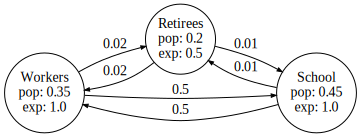

In [20]:
model_death = get_ptnet(p_death)
(generations = get_acset(gen_graph)) |> ModelStratify.show_graph

In [21]:
strat_model = ModelStratify.dem_strat(model_death, generations)
str_loc = ModelStratify.strat_location(strat_model, model_death, generations, locations(model_death, save(p_death), scale=144 * 0.4), locations(generations, save(gen_graph)), scale=1.4)
show_graph(Graph(strat_model, positions=str_loc))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V@Workers 
 
<!-- t3 -->
 
 t3 
 
 β_{UV}@Workers 
 
<!-- s1->t3 -->
 
 s1->t3 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 β_{VV}@Workers 
 
<!-- s1->t5 -->
 
 s1->t5 
 
 
 1 
 
<!-- t44 -->
 
 t44 
 
 crx_V′_I_U_2_1 
 
<!-- s1->t44 -->
 
 s1->t44 
 
 
 1 
 
<!-- t46 -->
 
 t46 
 
 crx_V′_I_V_2_1 
 
<!-- s1->t46 -->
 
 s1->t46 
 
 
 1 
 
<!-- t48 -->
 
 t48 
 
 crx_V′_I_U_3_1 
 
<!-- s1->t48 -->
 
 s1->t48 
 
 
 1 
 
<!-- t50 -->
 
 t50 
 
 crx_V′_I_V_3_1 
 
<!-- s1->t50 -->
 
 s1->t50 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S@Workers 
 
<!-- t1 -->
 
 t1 
 
 ν@Workers 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VU}@Workers 
 
<!-- s2->t4 -->
 
 s2->t4 
 
 
 1 
 
<!-- t9 -->
 
 t9 
 
 β_{UU}@Workers 
 
<!-- s2->t9 -->
 
 s2->t9 
 
 
 1 
 
<!-- t45 -->
 
 t45 
 
 crx_S′_I_V_2_1 
 
<!-- s2->t45 -->
 
 s2->t45 
 
 
 1 
 
<!-- t47 -->
 
 t47 
 
 crx_S′_I_U_2_1 
 
<!-- s2->t47 -->
 
 s2->t47 
 
 
 1 
 
<!-- t49 -->
 
 t49 
 
 crx_S′_I_V_3_1 
 
<!-- s2->t49 -->
 
 s2->t49 
 
 
 1 
 
<!-- t51 -->
 
 t51 
 
 crx_S′_I_U_3_1 
 
<!-- s2->t51 -->
 
 s2->t51 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R@Workers 
 
<!-- s4 -->
 
 s4 
 
 I_U@Workers 
 
<!-- t2 -->
 
 t2 
 
 δ_U@Workers 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- s4->t3 -->
 
 s4->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 γ_U@Workers 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s4->t9 -->
 
 s4->t9 
 
 
 1 
 
<!-- t32 -->
 
 t32 
 
 crx_V′_I_U_1_3 
 
<!-- s4->t32 -->
 
 s4->t32 
 
 
 1 
 
<!-- t35 -->
 
 t35 
 
 crx_S′_I_U_1_3 
 
<!-- s4->t35 -->
 
 s4->t35 
 
 
 1 
 
<!-- t40 -->
 
 t40 
 
 crx_V′_I_U_1_2 
 
<!-- s4->t40 -->
 
 s4->t40 
 
 
 1 
 
<!-- t43 -->
 
 t43 
 
 crx_S′_I_U_1_2 
 
<!-- s4->t43 -->
 
 s4->t43 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 D@Workers 
 
<!-- s6 -->
 
 s6 
 
 I_V@Workers 
 
<!-- s6->t4 -->
 
 s6->t4 
 
 
 1 
 
<!-- s6->t5 -->
 
 s6->t5 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 δ_V@Workers 
 
<!-- s6->t6 -->
 
 s6->t6 
 
 
 1 
 
<!-- t8 -->
 
 t8 
 
 γ_V@Workers 
 
<!-- s6->t8 -->
 
 s6->t8 
 
 
 1 
 
<!-- t33 -->
 
 t33 
 
 crx_S′_I_V_1_3 
 
<!-- s6->t33 -->
 
 s6->t33 
 
 
 1 
 
<!-- t34 -->
 
 t34 
 
 crx_V′_I_V_1_3 
 
<!-- s6->t34 -->
 
 s6->t34 
 
 
 1 
 
<!-- t41 -->
 
 t41 
 
 crx_S′_I_V_1_2 
 
<!-- s6->t41 -->
 
 s6->t41 
 
 
 1 
 
<!-- t42 -->
 
 t42 
 
 crx_V′_I_V_1_2 
 
<!-- s6->t42 -->
 
 s6->t42 
 
 
 1 
 
<!-- s7 -->
 
 s7 
 
 V@Retirees 
 
<!-- t12 -->
 
 t12 
 
 β_{UV}@Retirees 
 
<!-- s7->t12 -->
 
 s7->t12 
 
 
 1 
 
<!-- t14 -->
 
 t14 
 
 β_{VV}@Retirees 
 
<!-- s7->t14 -->
 
 s7->t14 
 
 
 1 
 
<!-- t28 -->
 
 t28 
 
 crx_V′_I_U_3_2 
 
<!-- s7->t28 -->
 
 s7->t28 
 
 
 1 
 
<!-- t30 -->
 
 t30 
 
 crx_V′_I_V_3_2 
 
<!-- s7->t30 -->
 
 s7->t30 
 
 
 1 
 
<!-- s7->t40 -->
 
 s7->t40 
 
 
 1 
 
<!-- s7->t42 -->
 
 s7->t42 
 
 
 1 
 
<!-- s8 -->
 
 s8 
 
 S@Retirees 
 
<!-- t10 -->
 
 t10 
 
 ν@Retirees 
 
<!-- s8->t10 -->
 
 s8->t10 
 
 
 1 
 
<!-- t13 -->
 
 t13 
 
 β_{VU}@Retirees 
 
<!-- s8->t13 -->
 
 s8->t13 
 
 
 1 
 
<!-- t18 -->
 
 t18 
 
 β_{UU}@Retirees 
 
<!-- s8->t18 -->
 
 s8->t18 
 
 
 1 
 
<!-- t29 -->
 
 t29 
 
 crx_S′_I_V_3_2 
 
<!-- s8->t29 -->
 
 s8->t29 
 
 
 1 
 
<!-- t31 -->
 
 t31 
 
 crx_S′_I_U_3_2 
 
<!-- s8->t31 -->
 
 s8->t31 
 
 
 1 
 
<!-- s8->t41 -->
 
 s8->t41 
 
 
 1 
 
<!-- s8->t43 -->
 
 s8->t43 
 
 
 1 
 
<!-- s9 -->
 
 s9 
 
 R@Retirees 
 
<!-- s10 -->
 
 s10 
 
 I_U@Retirees 
 
<!-- t11 -->
 
 t11 
 
 δ_U@Retirees 
 
<!-- s10->t11 -->
 
 s10->t11 
 
 
 1 
 
<!-- s10->t12 -->
 
 s10->t12 
 
 
 1 
 
<!-- t16 -->
 
 t16 
 
 γ_U@Retirees 
 
<!-- s10->t16 -->
 
 s10->t16 
 
 
 1 
 
<!-- s10->t18 -->
 
 s10->t18 
 
 
 1 
 
<!-- t36 -->
 
 t36 
 
 crx_V′_I_U_2_3 
 
<!-- s10->t36 -->
 
 s10->t36 
 
 
 1 
 
<!-- t39 -->
 
 t39 
 
 crx_S′_I_U_2_3 
 
<!-- s10-

In [36]:
export_html(strat_sg)

HTML{String}("<svg xmlns=\"http://www.w3.org/2000/svg\" width=\"95%\" height=\"300px\"><style>\n.katex { font-size: 1.5em; }\n</style><defs><pattern id=\"grid\" width=\"13.995221406292\" height=\"13.995221406292\" x=\"113.24157376525962\" y=\"93.13295205654997\" patternUnits=\"userSpaceOnUse\"><path d=\"M 13.995221406292,0 L 0,0 L 0,13.995221406292\" fill=\"none\" stroke=\"gray\" stroke-width=\"1\"/></pattern><marker id=\"resistor\" viewBox=\"0 0 82.5 30\" refX=\"45\" refY=\"15\" markerWidth=\"30\" markerHeight=\"10\" orient=\"auto\"><g transform=\"translate(0 15)\"><rect width=\"90\" height=\"30\" x=\"0\" y=\"-15\" style=\"fill:black;stroke:none\"/><polyline points=\"0.0,0.0 15.0,0.0 22.5,-15.0 30.0,15.0 37.5,-15.0 45.0,15.0 52.5,-15.0 60.0,15.0 67.5,0.0 82.5,0.0\" style=\"stroke-width:2px;stroke:white;fill:none\"/></g></marker><marker id=\"capacitor\" viewBox=\"0 0 60 60\" refX=\"30\" refY=\"30\" markerWidth=\"20\" markerHeight=\"20\" orient=\"auto\"><g transform=\"translate(30 30)\"><rect width=\"60\" height=\"60\" x=\"-30\" y=\"-30\" style=\"stroke: none; fill: black;\"/><polyline points=\"-30,0 -10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"30,0 10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"-10,30 -10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"10,30 10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/></g></marker><marker id=\"arrow-hovered\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"lightgrey\" stroke=\"black\"/></marker><marker id=\"arrow\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"white\" stroke=\"black\"/></marker><marker id=\"arrow-selected\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"yellow\" stroke=\"black\"/></marker><marker id=\"arrow-solid\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"black\" stroke=\"black\"/></marker></defs><g transform=\"matrix(0.23325369010486666 0 0 0.23325369010486666 113.24157376525962 93.13295205654997)\"><g><path d=\"M 2996.8999999999996,97.35000000000002 C 2810.14,71.17000000000004 2810.14,71.17000000000004 2623.38,44.990000000000066 C 2436.62,18.810000000000088 2436.62,18.810000000000088 2249.86,-7.369999999999891\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 2729.36,125.14000000000004 C 2524.26562288487,309.9401973943932 2524.26562288487,309.9401973943932 2309.7506228848697,483.0676973943931 C 2095.23562288487,656.1951973943932 2095.23562288487,656.1951973943932 1871.3,817.65\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 2243.4199999999996,579.048 C 2504.375144186555,444.9489048396513 2504.375144186555,444.9489048396513 2771.495144186555,324.52440483965125 C 3038.615144186555,204.09990483965126 3038.615144186555,204.09990483965126 3311.8999999999996,97.35000000000002\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 1299.26,-217.58000000000004 C 1082.12,-217.59750000000003 1082.12,-217.59750000000003 864.98,-217.615 C 647.84,-217.6325 647.84,-217.6325 430.7,-217.64999999999998\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 2729.36,125.14000000000004 C 2874.995,39.44250000000004 2874.995,39.44250000000004 3020.63,-46.25499999999997 C 3166.265,-131.9525 3166.265,-131.9525 3311.8999999999996,-217.64999999999998\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 1871.3,817.65 C 1897.55,804.525 1897.55,804.525 1923.8,791.4 C 1950.05,778.275 19

In [23]:
# Change some of the initial conditions and rates for different populations

strat_model[:δ_V, :School] *= 0.1
strat_model[:δ_U, :School] *= 0.1
strat_model[:δ_V, :Retirees] *= 1.5
strat_model[:δ_U, :Retirees] *= 1.5

strat_model[:I_U, :Retirees] = 0.0
strat_model[:I_U, :School] = 0.0;

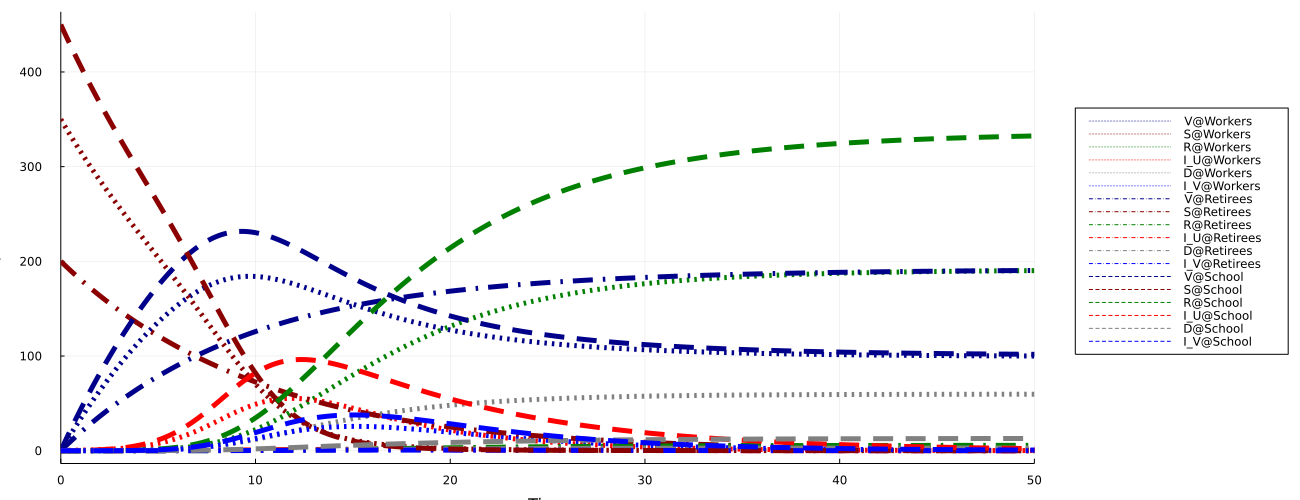

In [24]:
tspan = (0.0, 50.0)
sol = solution(strat_model, tspan)
linestyles = Dict("School"=>:dash, "Retirees"=>:dashdot, "Workers"=>:dot)
linecolors = Dict("S"=>:darkred, "V"=>:darkblue, "I_U"=>:red, "I_V"=>:blue, "R"=>:green, "D"=>:gray)
times = range(tspan..., length=1000)

states = ["V", "I_U", "I_V", "D", "R", "S"]
pops = ["School", "Retirees", "Workers"]
names = filter(s ->first(split("$s", "@")) ∈ states && last(split("$s", "@")) ∈ pops,  snames(strat_model))
plot(times, hcat(collect([sol(t)[n] for t in times] for n in names)...); linestyle=reshape([linestyles[last(split("$s", "@"))] for s in names], (1,length(names))),
          color=reshape([linecolors[first(split("$s", "@"))] for s in names], (1,length(names))), labels=reshape(string.(names), (1,length(names))), legend=:outerright, size=(1.3e3,5e2), xrange=tspan)

In [25]:
fin_met = Sensitivity.final_metric(strat_model, vcat([[Symbol(:D, "@$i")] for i in [:School, :Workers, :Retirees]]...), t_range=(0.0,50.0))
sens = Sensitivity.sensitivity(fin_met, rates(strat_model)) .* rates(strat_model) ./ fin_met(rates(strat_model))
sens *= -1
log_sens = signed_log(sens)
max_rng = maximum(abs.(log_sens))
show_graph(Sensitivity.GraphHeatmap(strat_model, log_sens, clims=(-max_rng, max_rng), positions=str_loc))

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.48.0 (20210717.1556)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- s1 -->
 
 s1 
 
 V@Workers 
 
<!-- t3 -->
 
 t3 
 
 β_{UV}@Workers 
 
<!-- s1->t3 -->
 
 s1->t3 
 
 
 1 
 
<!-- t5 -->
 
 t5 
 
 β_{VV}@Workers 
 
<!-- s1->t5 -->
 
 s1->t5 
 
 
 1 
 
<!-- t44 -->
 
 t44 
 
 crx_V′_I_U_2_1 
 
<!-- s1->t44 -->
 
 s1->t44 
 
 
 1 
 
<!-- t46 -->
 
 t46 
 
 crx_V′_I_V_2_1 
 
<!-- s1->t46 -->
 
 s1->t46 
 
 
 1 
 
<!-- t48 -->
 
 t48 
 
 crx_V′_I_U_3_1 
 
<!-- s1->t48 -->
 
 s1->t48 
 
 
 1 
 
<!-- t50 -->
 
 t50 
 
 crx_V′_I_V_3_1 
 
<!-- s1->t50 -->
 
 s1->t50 
 
 
 1 
 
<!-- s2 -->
 
 s2 
 
 S@Workers 
 
<!-- t1 -->
 
 t1 
 
 ν@Workers 
 
<!-- s2->t1 -->
 
 s2->t1 
 
 
 1 
 
<!-- t4 -->
 
 t4 
 
 β_{VU}@Workers 
 
<!-- s2->t4 -->
 
 s2->t4 
 
 
 1 
 
<!-- t9 -->
 
 t9 
 
 β_{UU}@Workers 
 
<!-- s2->t9 -->
 
 s2->t9 
 
 
 1 
 
<!-- t45 -->
 
 t45 
 
 crx_S′_I_V_2_1 
 
<!-- s2->t45 -->
 
 s2->t45 
 
 
 1 
 
<!-- t47 -->
 
 t47 
 
 crx_S′_I_U_2_1 
 
<!-- s2->t47 -->
 
 s2->t47 
 
 
 1 
 
<!-- t49 -->
 
 t49 
 
 crx_S′_I_V_3_1 
 
<!-- s2->t49 -->
 
 s2->t49 
 
 
 1 
 
<!-- t51 -->
 
 t51 
 
 crx_S′_I_U_3_1 
 
<!-- s2->t51 -->
 
 s2->t51 
 
 
 1 
 
<!-- s3 -->
 
 s3 
 
 R@Workers 
 
<!-- s4 -->
 
 s4 
 
 I_U@Workers 
 
<!-- t2 -->
 
 t2 
 
 δ_U@Workers 
 
<!-- s4->t2 -->
 
 s4->t2 
 
 
 1 
 
<!-- s4->t3 -->
 
 s4->t3 
 
 
 1 
 
<!-- t7 -->
 
 t7 
 
 γ_U@Workers 
 
<!-- s4->t7 -->
 
 s4->t7 
 
 
 1 
 
<!-- s4->t9 -->
 
 s4->t9 
 
 
 1 
 
<!-- t32 -->
 
 t32 
 
 crx_V′_I_U_1_3 
 
<!-- s4->t32 -->
 
 s4->t32 
 
 
 1 
 
<!-- t35 -->
 
 t35 
 
 crx_S′_I_U_1_3 
 
<!-- s4->t35 -->
 
 s4->t35 
 
 
 1 
 
<!-- t40 -->
 
 t40 
 
 crx_V′_I_U_1_2 
 
<!-- s4->t40 -->
 
 s4->t40 
 
 
 1 
 
<!-- t43 -->
 
 t43 
 
 crx_S′_I_U_1_2 
 
<!-- s4->t43 -->
 
 s4->t43 
 
 
 1 
 
<!-- s5 -->
 
 s5 
 
 D@Workers 
 
<!-- s6 -->
 
 s6 
 
 I_V@Workers 
 
<!-- s6->t4 -->
 
 s6->t4 
 
 
 1 
 
<!-- s6->t5 -->
 
 s6->t5 
 
 
 1 
 
<!-- t6 -->
 
 t6 
 
 δ_V@Workers 
 
<!-- s6->t6 -->
 
 s6->t6 
 
 
 1 
 
<!-- t8 -->
 
 t8 
 
 γ_V@Workers 
 
<!-- s6->t8 -->
 
 s6->t8 
 
 
 1 
 
<!-- t33 -->
 
 t33 
 
 crx_S′_I_V_1_3 
 
<!-- s6->t33 -->
 
 s6->t33 
 
 
 1 
 
<!-- t34 -->
 
 t34 
 
 crx_V′_I_V_1_3 
 
<!-- s6->t34 -->
 
 s6->t34 
 
 
 1 
 
<!-- t41 -->
 
 t41 
 
 crx_S′_I_V_1_2 
 
<!-- s6->t41 -->
 
 s6->t41 
 
 
 1 
 
<!-- t42 -->
 
 t42 
 
 crx_V′_I_V_1_2 
 
<!-- s6->t42 -->
 
 s6->t42 
 
 
 1 
 
<!-- s7 -->
 
 s7 
 
 V@Retirees 
 
<!-- t12 -->
 
 t12 
 
 β_{UV}@Retirees 
 
<!-- s7->t12 -->
 
 s7->t12 
 
 
 1 
 
<!-- t14 -->
 
 t14 
 
 β_{VV}@Retirees 
 
<!-- s7->t14 -->
 
 s7->t14 
 
 
 1 
 
<!-- t28 -->
 
 t28 
 
 crx_V′_I_U_3_2 
 
<!-- s7->t28 -->
 
 s7->t28 
 
 
 1 
 
<!-- t30 -->
 
 t30 
 
 crx_V′_I_V_3_2 
 
<!-- s7->t30 -->
 
 s7->t30 
 
 
 1 
 
<!-- s7->t40 -->
 
 s7->t40 
 
 
 1 
 
<!-- s7->t42 -->
 
 s7->t42 
 
 
 1 
 
<!-- s8 -->
 
 s8 
 
 S@Retirees 
 
<!-- t10 -->
 
 t10 
 
 ν@Retirees 
 
<!-- s8->t10 -->
 
 s8->t10 
 
 
 1 
 
<!-- t13 -->
 
 t13 
 
 β_{VU}@Retirees 
 
<!-- s8->t13 -->
 
 s8->t13 
 
 
 1 
 
<!-- t18 -->
 
 t18 
 
 β_{UU}@Retirees 
 
<!-- s8->t18 -->
 
 s8->t18 
 
 
 1 
 
<!-- t29 -->
 
 t29 
 
 crx_S′_I_V_3_2 
 
<!-- s8->t29 -->
 
 s8->t29 
 
 
 1 
 
<!-- t31 -->
 
 t31 
 
 crx_S′_I_U_3_2 
 
<!-- s8->t31 -->
 
 s8->t31 
 
 
 1 
 
<!-- s8->t41 -->
 
 s8->t41 
 
 
 1 
 
<!-- s8->t43 -->
 
 s8->t43 
 
 
 1 
 
<!-- s9 -->
 
 s9 
 
 R@Retirees 
 
<!-- s10 -->
 
 s10 
 
 I_U@Retirees 
 
<!-- t11 -->
 
 t11 
 
 δ_U@Retirees 
 
<!-- s10->t11 -->
 
 s10->t11 
 
 
 1 
 
<!-- s10->t12 -->
 
 s10->t12 
 
 
 1 
 
<!-- t16 -->
 
 t16 
 
 γ_U@Retirees 
 
<!-- s10->t16 -->
 
 s10->t16 
 
 
 1 
 
<!-- s10->t18 -->
 
 s10->t18 
 
 
 1 
 
<!-- t36 -->
 
 t36 
 
 crx_V′_I_U_2_3 
 
<!-- s10->t36 -->
 
 s10->t36 
 
 
 1 
 
<!-- t39 -->
 
 t39 
 
 crx_S′_I_U_2_3 
 
<!-- s10-

In [26]:
vax_vals = Highlighter((data, i, j)->(startswith("$(data[i,1])", "ν")), crayon"fg:black bold bg:yellow")
sens_table(sens; highlighters=(vax_vals,))

┌─────────────────┬──────────────┐
│      Transition │  Sensitivity │
├─────────────────┼──────────────┤
│       ν@Workers │     0.848943 │
│     γ_U@Workers │     0.505455 │
│        ν@School │     0.396903 │
│      γ_U@School │     0.263965 │
│     γ_V@Workers │    0.0876328 │
│      ν@Retirees │    0.0534387 │
│      γ_V@School │    0.0461593 │
│    γ_U@Retirees │    0.0182882 │
│    γ_V@Retirees │   0.00436017 │
│  crx_V′_I_V_2_3 │  -1.17187e-6 │
│  crx_S′_I_V_2_3 │  -3.47378e-6 │
│  crx_V′_I_U_2_3 │  -5.37703e-6 │
│  crx_V′_I_V_2_1 │  -6.16468e-6 │
│  crx_S′_I_V_2_1 │  -1.38395e-5 │
│  crx_V′_I_U_2_1 │  -1.72182e-5 │
│  crx_S′_I_U_2_3 │  -4.44581e-5 │
│  crx_S′_I_U_2_1 │  -9.81893e-5 │
│ β_{VV}@Retirees │  -0.00045537 │
│  crx_V′_I_V_3_2 │  -0.00050463 │
│  crx_V′_I_V_1_2 │ -0.000683066 │
│ β_{UV}@Retirees │ -0.000960095 │
│  crx_V′_I_U_1_2 │  -0.00132267 │
│  crx_V′_I_U_3_2 │  -0.00136724 │
│    δ_V@Retirees │  -0.00207656 │
│ β_{VU}@Retirees │  -0.00256549 │
│  crx_V′_I_V_1_3 │ 

## Long Covid Example

In [43]:
export_html(p_lcv)

HTML{String}("<svg xmlns=\"http://www.w3.org/2000/svg\" width=\"95%\" height=\"300px\"><style>\n.katex { font-size: 1.5em; }\n</style><defs><pattern id=\"grid\" width=\"30\" height=\"30\" x=\"1\" y=\"-29\" patternUnits=\"userSpaceOnUse\"><path d=\"M 30,0 L 0,0 L 0,30\" fill=\"none\" stroke=\"gray\" stroke-width=\"1\"/></pattern><marker id=\"resistor\" viewBox=\"0 0 82.5 30\" refX=\"45\" refY=\"15\" markerWidth=\"30\" markerHeight=\"10\" orient=\"auto\"><g transform=\"translate(0 15)\"><rect width=\"90\" height=\"30\" x=\"0\" y=\"-15\" style=\"fill:black;stroke:none\"/><polyline points=\"0.0,0.0 15.0,0.0 22.5,-15.0 30.0,15.0 37.5,-15.0 45.0,15.0 52.5,-15.0 60.0,15.0 67.5,0.0 82.5,0.0\" style=\"stroke-width:2px;stroke:white;fill:none\"/></g></marker><marker id=\"capacitor\" viewBox=\"0 0 60 60\" refX=\"30\" refY=\"30\" markerWidth=\"20\" markerHeight=\"20\" orient=\"auto\"><g transform=\"translate(30 30)\"><rect width=\"60\" height=\"60\" x=\"-30\" y=\"-30\" style=\"stroke: none; fill: black;\"/><polyline points=\"-30,0 -10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"30,0 10,0\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"-10,30 -10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/><polyline points=\"10,30 10,-30\" style=\"stroke-width: 3px; stroke: white; fill: none;\"/></g></marker><marker id=\"arrow-hovered\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"lightgrey\" stroke=\"black\"/></marker><marker id=\"arrow\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"white\" stroke=\"black\"/></marker><marker id=\"arrow-selected\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"yellow\" stroke=\"black\"/></marker><marker id=\"arrow-solid\" viewBox=\"0 0 10 10\" refX=\"5\" refY=\"5\" markerWidth=\"6\" markerHeight=\"6\" orient=\"auto\"><path d=\"M 0,0 L 10,5 L 0, 10 Z\" style=\"stroke-width: 0.5px;\" fill=\"black\" stroke=\"black\"/></marker></defs><g transform=\"matrix(0.5 0 0 0.5 1 -29)\"><g><path d=\"M 360,120 C 405,100 405,100 450,100 C 495,100 495,100 540,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 225,450 225,450 270,420 C 315,390 315,390 360,360\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 180,435 180,435 180,390 C 180,345 180,345 180,300\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,360 C 405,390 405,390 450,420 C 495,450 495,450 540,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 483,429 483,429 438,369 C 393,309 393,309 360,240\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 600,480 600,480 660,480 C 720,480 720,480 780,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 570,465 570,465 600,450 C 630,435 630,435 660,420\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,480 C 495,500 495,500 450,500 C 405,500 405,500 360,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,480 C 225,480 225,480 270,480 C 315,480 315,480 360,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 780,120 C 780,165 780,165 780,210 C 780,255 780,255 780,300\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 360,480 C 405,480 405,480 450,480 C 495,480 495,480 540,480\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 540,120 C 600,120 600,120 660,120 C 720,120 720,120 780,120\" stroke=\"black\" marker-mid=\"url(#arrow)\" fill=\"none\"/><path d=\"M 180,120 C 225,120 225,1

In [28]:
load(p_lcv, "SVIIRD.sema");

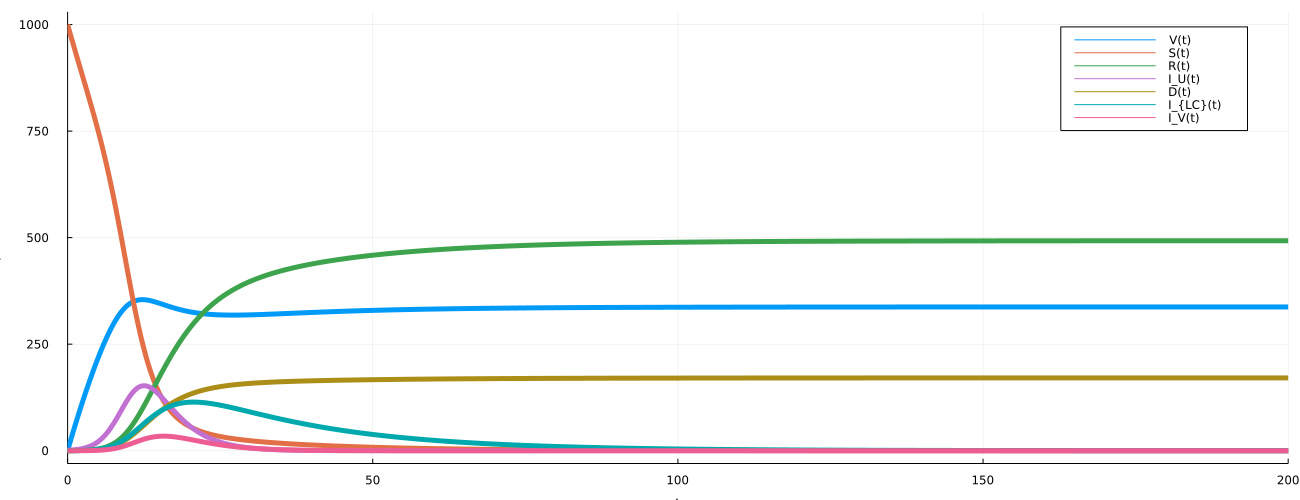

In [41]:
lcv_model = get_ptnet(p_lcv)
tspan = (0.0, 200.0)
sol = solution(lcv_model, tspan)
plot(sol, xrange=tspan, size=(1.3e3,5e2))

# Acknowledgements

<div><h2>AlgebraicJulia 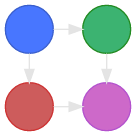</h2> </div>

This library provides the tooling necessary for both the interactive editing of models and the stratification of these models.

<div><h2>SciML 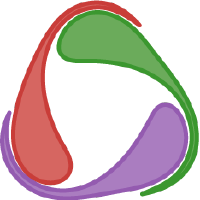</h2> </div>

This library provides the basic sensitivity analysis and simulation tooling.

## Julia Community

This work would not be possible without the high level of work put in to developing the thriving community of Julia developers, especially the developers who are involved in the AlgebraicJulia and SciML projects.

## Relevant Resources

John Baez and Jade Master, 2020. Open Petri nets. DOI:10.1017/S0960129520000043. arXiv:1808.05415

Micah Halter et al. Compositional Scientific Computing with Catlab and SemanticModels. arXiv:2005.04831